<a href="https://colab.research.google.com/github/sarenales/PrototypesVulnerabilities/blob/main/EjemploPrototipos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aprendizaje Basado en prototipos ejemplo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.01MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
class PrototypeNetwork(nn.Module):
    def __init__(self, num_prototypes=10, latent_dim=64, input_dim=28*28):
        super(PrototypeNetwork, self).__init__()
        # Codificador
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Prototipos
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, latent_dim))

        # Clasificador
        self.classifier = nn.Linear(num_prototypes, 10)  # 10 clases en MNIST

        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),  # Reconstruir la entrada original (tamaño 28x28 aplanado)
            nn.Sigmoid()  # Normalizar entre 0 y 1
        )

    def forward(self, x):
        # Codificador
        x = x.view(x.size(0), -1)  # Aplanar la imagen
        z = self.encoder(x)

        # Similitudes con prototipos
        prototype_distances = torch.cdist(z, self.prototypes, p=2)
        similarities = -prototype_distances  # Similitudes inversas a la distancia

        # Clasificador
        logits = self.classifier(similarities)

        # Reconstrucción (añadido)
        reconstruction = self.decoder(z)

        return logits, similarities, reconstruction


In [ ]:
def prototype_loss(logits, targets, similarities, prototypes, original_input, reconstruction, alpha=1.0, beta=0.1):
    # Pérdida de clasificación
    classification_loss = nn.CrossEntropyLoss()(logits, targets)

    # Pérdida de dispersión de prototipos (penaliza prototipos muy cercanos)
    prototype_distances = torch.cdist(prototypes, prototypes, p=2)
    diversity_loss = torch.mean(torch.triu(prototype_distances, diagonal=1))

    # Pérdida de reconstrucción
    reconstruction_loss = nn.MSELoss()(reconstruction, original_input.view(original_input.size(0), -1))

    # Pérdida total
    total_loss = classification_loss + alpha * (1 / diversity_loss) + beta * reconstruction_loss
    return total_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypeNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo de entrenamiento
for epoch in range(10):  # 10 épocas
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        logits, similarities = model(images)

        # Calcular pérdida
        loss = prototype_loss(logits, labels, similarities, model.prototypes)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


ValueError: too many values to unpack (expected 2)

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits, _ = model(images)
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")


Test Accuracy: 96.46%


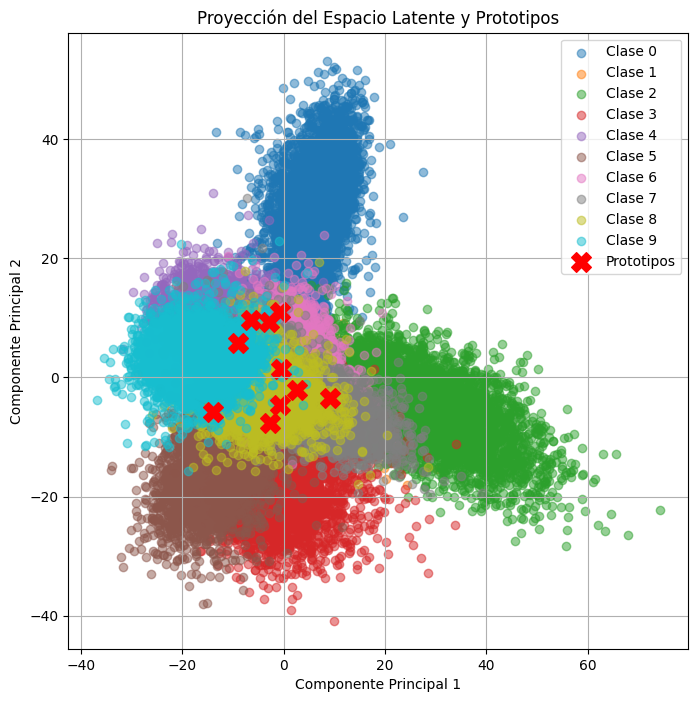

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Obtener las representaciones latentes (f(x)) y prototipos
model.eval()
latent_features = []
labels = []

with torch.no_grad():
    for images, lbls in train_loader:
        images = images.to(device)
        z = model.encoder(images.view(images.size(0), -1))
        latent_features.append(z.cpu().numpy())
        labels.extend(lbls.numpy())

# Concatenar latentes
latent_features = np.vstack(latent_features)
labels = np.array(labels)

# Reducir dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)
prototypes_2d = pca.transform(model.prototypes.detach().cpu().numpy())

# Graficar
plt.figure(figsize=(8, 8))
for i in range(10):  # 10 clases en MNIST
    idx = labels == i
    plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=f"Clase {i}", alpha=0.5)

plt.scatter(prototypes_2d[:, 0], prototypes_2d[:, 1], color="red", marker="X", s=200, label="Prototipos")
plt.legend()
plt.title("Proyección del Espacio Latente y Prototipos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()


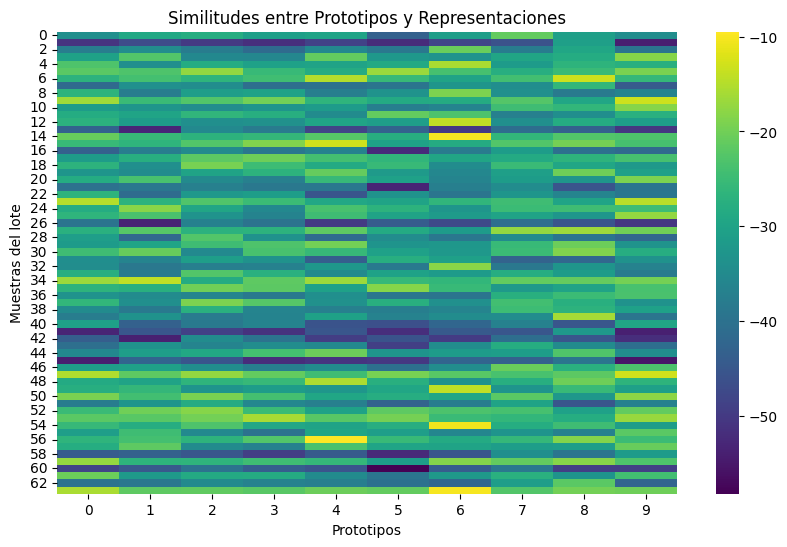

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular similitudes entre prototipos y un lote de datos
images, _ = next(iter(train_loader))
images = images.to(device)
z = model.encoder(images.view(images.size(0), -1))
similarities = -torch.cdist(z, model.prototypes, p=2).detach().cpu().numpy()

# Graficar la matriz de similitud
plt.figure(figsize=(10, 6))
sns.heatmap(similarities, cmap="viridis", annot=False)
plt.title("Similitudes entre Prototipos y Representaciones")
plt.xlabel("Prototipos")
plt.ylabel("Muestras del lote")
plt.show()


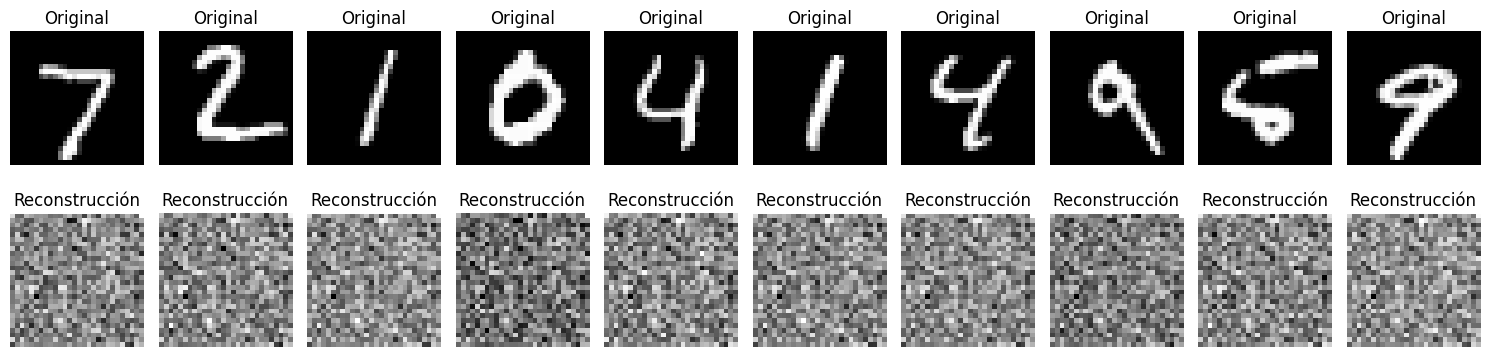

In [ ]:
# Seleccionar un lote de imágenes
images, _ = next(iter(test_loader))
images = images.to(device)

# Reconstrucción
with torch.no_grad():
    _, _, reconstructions = model(images)

# Visualización
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Imagen original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Reconstrucción
    axes[1, i].imshow(reconstructions[i].cpu().view(28, 28), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstrucción")
plt.tight_layout()
plt.show()
